# 0 - Instalation of modules

#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [117]:
%reset

# 1 - Importing modules

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [2]:
data_folder = "../../Dataset/Movie/"

In [122]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [123]:
#On garde les NB_FILM films les plus notés
NB_FILM = 500
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(10944751, 3)

In [124]:
#On garde les users qui ont données une note sur au moins THRESH_USER % des films
THRESH_USER = 0.25
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [125]:
#On fait notre pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
user_title_df.to_csv(f"{data_folder}test_for_users.csv")
user_title_df.shape

(24710, 500)

# 4 - Colaborative filtering

In [3]:
#Récupérer les données si elles sont en local
user_title_df = pd.read_csv(f"{data_folder}test_for_users.csv", index_col=0)
user_title_df.shape

(24710, 500)

In [4]:
#Standardisation des lignes pour supprimer les biais
def standardize(row):
    return (row - row.mean())/row.std()

In [5]:
def keep_efficiant_values(cos_df, eps):
    cos_users_thresh = cos_df[(cos_df>=eps) | (cos_df<=-eps)]
    return cos_users_thresh.dropna(thresh=1, axis=0).dropna(thresh=1, axis=1)

## 4.1 - Users to users

In [6]:
user_title_std = user_title_df.apply(standardize, axis=1).fillna(0)
user_title_std.shape

(24710, 500)

In [7]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(user_title_std)
cos_users_df = pd.DataFrame(cos, index=user_title_std.index, columns=user_title_std.index)
np.fill_diagonal(cos_users_df.values, 0)
del(cos)

In [41]:
#On devine la note en fonction des candidtats similaires
def guess_rate_cluster(user, title, N):
    rate = 0
    coeff = 0

    for i in cos_users_df.loc[user].sort_values(ascending=False).drop(user).index[:N]:
        r = user_title_df.loc[i, title]
        if not (pd.isnull(r)):
            c = cos_users_df.loc[i, user]
            rate += r*c
            coeff += c
    
    if (coeff != 0):
        return rate/coeff
    else:
        return 2.5

In [27]:
#On devine la note en fonction de tous les candidats
def guess_rate_all(user, title):
    rate = 0
    coef = 0

    for i in user_title_std.drop(user).index:
        r = user_title_df.loc[i, title]
        if not (pd.isnull(r)):
            c = cos_users_df.loc[user, i]
            rate += c*r
            coef += c

    if (coef == 0):
            return 2.5
    else:   
        return rate/coef

In [10]:
cos_users_thresh = keep_efficiant_values(cos_users_df, 0.75)
cluster = len(cos_users_thresh) - np.sum(cos_users_thresh.isna(), axis=0).sort_values()

In [11]:
#On compare les deux méthodes
from time import time

compare_time = {}

for N in tqdm([1, 5, 10 , 15]):
    compare_time[f"Cluster {N}"] = {"Cluster" : {"Times" : [], "Rates" : []}, "All" : {"Times" : [], "Rates" : []}}

    keep_index = cluster[(cluster == N) | (cluster == N+1) | (cluster == N-1)].index[:20]
    titles = user_title_df.columns
    sup = []
    positif = []

    for user in tqdm(keep_index, leave=False):
        for title in titles[:100]:
            start = time()
            cluster_rate = guess_rate_cluster(user, title, N)
            cluster_time = time() - start
            compare_time[f"Cluster {N}"]["Cluster"]["Rates"].append(cluster_rate)
            compare_time[f"Cluster {N}"]["Cluster"]["Times"].append(cluster_time)

            start = time()
            all_rate = guess_rate_all(user, title)
            all_time = time() - start
            compare_time[f"Cluster {N}"]["All"]["Rates"].append(all_rate)
            compare_time[f"Cluster {N}"]["All"]["Times"].append(all_time)
            
            sup.append(1) if (cluster_rate - all_rate < 0) else sup.append(0) 
            positif.append(1) if (cluster_time - all_time > 0) else positif.append(0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

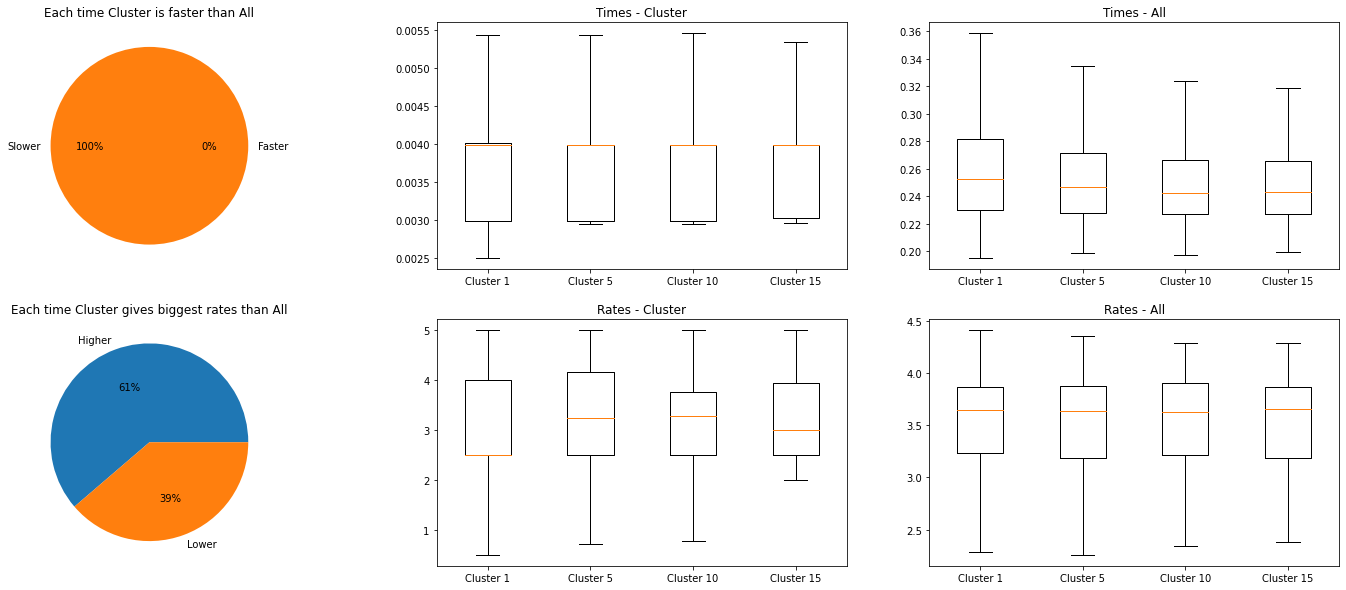

In [13]:
#On affiche graphiquement le comparatif
plt.figure(figsize=(25,10))

k = 1
for stat in ["Times", "Rates"]:
    plt.subplot(2, 3, k)
    if (k == 1):
        n = np.sum(positif)
        plt.pie([n, len(positif)-n], labels=["Faster", "Slower"], autopct='%.0f%%')
        plt.title("Each time Cluster is faster than All")
    elif (k == 4):
        n = np.sum(sup)
        plt.pie([n, len(sup)-n], labels=["Higher", "Lower"], autopct='%.0f%%')
        plt.title("Each time Cluster gives biggest rates than All")
    k += 1

    for method in ["Cluster", "All"]:
        plots = []
        labels = []

        for key in compare_time.keys():
            labels.append(key)
            plots.append(compare_time[key][method][stat])

        plt.subplot(2, 3, k)
        plt.boxplot(plots, labels=labels, showfliers=False)
        plt.title(f"{stat} - {method}")

        k += 1

plt.show()

In [43]:
compare = {}

for N in tqdm([1, 5, 10 , 15]):
    compare[f"Cluster {N}"] = {"True" : [], "Cluster" : [], "All" : []}

    keep_index = cluster[(cluster == N) | (cluster == N+1) | (cluster == N-1)].index[:20]
    for user in tqdm(keep_index, leave=False):
        all_rated_film = user_title_df.loc[user].dropna(axis=0)[:50]
        compare[f"Cluster {N}"]["True"] += all_rated_film.values.tolist()
        
        for movie in all_rated_film.index:
            compare[f"Cluster {N}"]["Cluster"].append(guess_rate_cluster(user, movie, N))
            compare[f"Cluster {N}"]["All"].append(guess_rate_all(user, movie))

compare_df = pd.DataFrame.from_dict(compare)
#compare_df.to_csv(f"{data_folder}compare_true_cluster_all.csv")
del(compare)


delta = {"Cluster" : {}, "All" : {}}

for col in compare_df.columns:
    delta["Cluster"][col] = []
    delta["All"][col] = []

    for i in range(len(compare_df[col]["Cluster"])):
        delta["Cluster"][col].append(compare_df[col]["True"][i]-compare_df[col]["Cluster"][i])
        delta["All"][col].append(compare_df[col]["True"][i]-compare_df[col]["All"][i])

compare_delta_df = pd.DataFrame.from_dict(delta)
del(delta)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

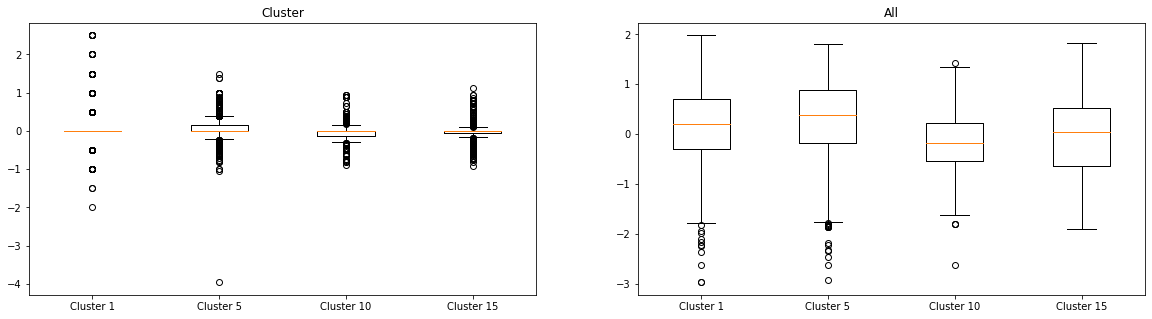

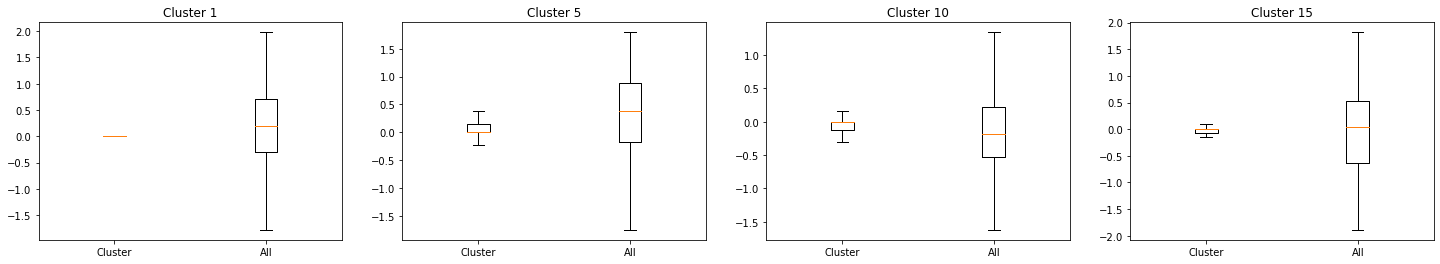

In [45]:
plt.figure(figsize=(20,5))

k = 1
for col in compare_delta_df.columns:
    plt.subplot(1, 2, k)

    plots = []
    labels = []
    for ind in compare_delta_df[col].index:
        plots.append(compare_delta_df[col][ind])
        labels.append(ind)

    plt.boxplot(plots, labels=labels, showfliers=True)
    plt.title(col)

    k += 1

plt.figure(figsize=(25,4))

k = 1
for clust in compare_delta_df.index:
    plt.subplot(1, 4, k)
    plt.boxplot([elem for elem in compare_delta_df.loc[clust]], labels=["Cluster", "All"], showfliers=False)
    plt.title(clust)
    k += 1

#plt.savefig("img/compare_cluster_all_by_cluster.jpg", dpi=200)
plt.show()

In [16]:
non_cluster = cos_users_df.index[~cos_users_df.index.isin(cluster.index)][:20]

compare = {}

for N in tqdm([5, 10, 25, 50, 100, 1000]):
    compare[f"Cluster {N}"] = {"True" : [], "Cluster" : [], "All" : []}

    for user in tqdm(non_cluster, leave=False):
        all_rated_film = user_title_df.loc[user].dropna(axis=0)[:50]
        compare[f"Cluster {N}"]["True"] += all_rated_film.values.tolist()
        
        for movie in all_rated_film.index:
            compare[f"Cluster {N}"]["Cluster"].append(guess_rate_cluster(user, movie, N))
            compare[f"Cluster {N}"]["All"].append(guess_rate_all(user, movie))

compare_df = pd.DataFrame.from_dict(compare)
#compare_df.to_csv(f"{data_folder}compare_true_cluster_all.csv")
del(compare)


delta = {"Cluster" : {}, "All" : {}}

for col in compare_df.columns:
    delta["Cluster"][col] = []
    delta["All"][col] = []

    for i in range(len(compare_df[col]["Cluster"])):
        delta["Cluster"][col].append(compare_df[col]["True"][i]-compare_df[col]["Cluster"][i])
        delta["All"][col].append(compare_df[col]["True"][i]-compare_df[col]["All"][i])

compare_delta_df = pd.DataFrame.from_dict(delta)
del(delta)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

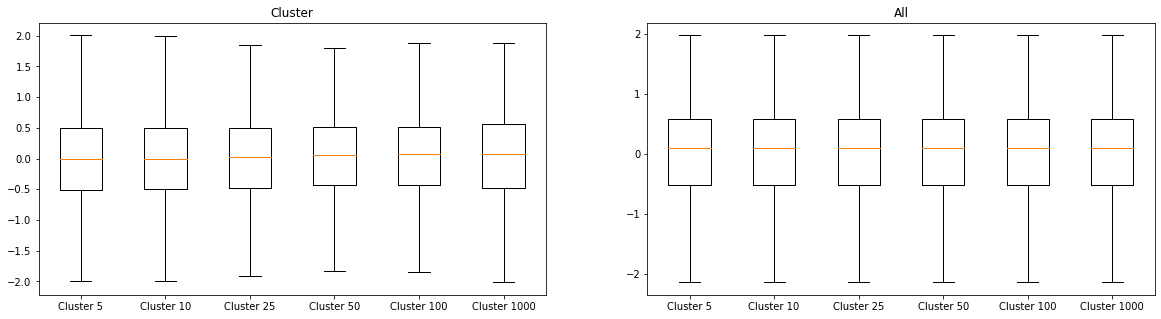

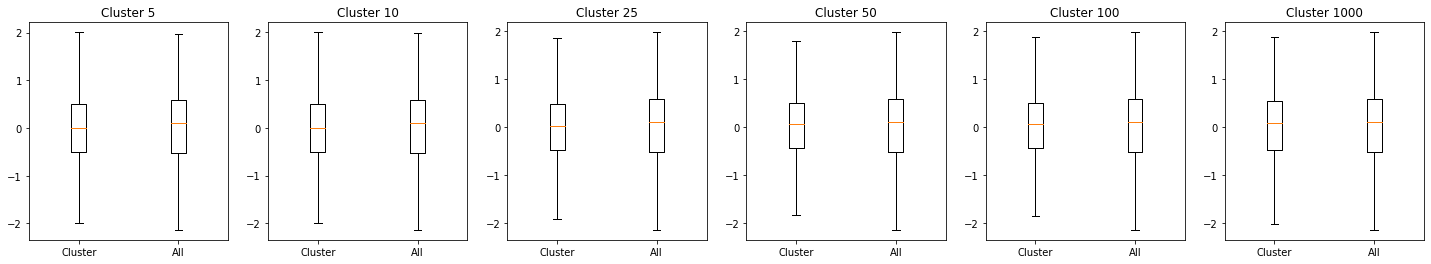

In [17]:
plt.figure(figsize=(20,5))

k = 1
for col in compare_delta_df.columns:
    plt.subplot(1, 2, k)

    plots = []
    labels = []
    for ind in compare_delta_df[col].index:
        plots.append(compare_delta_df[col][ind])
        labels.append(ind)

    plt.boxplot(plots, labels=labels, showfliers=False)
    plt.title(col)

    k += 1


plt.figure(figsize=(25,4))

k = 1
for clust in compare_delta_df.index:
    plt.subplot(1, 6, k)
    plt.boxplot([elem for elem in compare_delta_df.loc[clust]], labels=["Cluster", "All"], showfliers=False)
    plt.title(clust)
    k += 1

#plt.savefig("img/compare_cluster_all_by_cluster.jpg", dpi=200)
plt.show()

In [62]:
def guess_rate(user_id, title):
    L = len(cos_users_df[user_id][cos_users_df[user_id] > 0.75].index)
    if (L >= 3):
        return guess_rate_cluster(user_id, title, L)
    else:
        return guess_rate_cluster(user_id, title, 50)

In [86]:
users = cos_users_df.index[:100]
rates = {"true" : [], "guess" : [], "clust" : []}
delta = {"guess" : [], "clust" : []}

for user in tqdm(users):
    all_rated_film = user_title_df.loc[user].dropna(axis=0)[:150]
    rates["true"] += all_rated_film.values.tolist()

    for movie in all_rated_film.index:
        rates["guess"].append(guess_rate(user, movie))
        rates["clust"].append(guess_rate_cluster(user, movie, 100))

for i in range(len(rates["clust"])):
    r = rates["true"][i]
    delta["guess"].append(r- rates["guess"][i])
    delta["clust"].append(r- rates["clust"][i])


  0%|          | 0/100 [00:00<?, ?it/s]

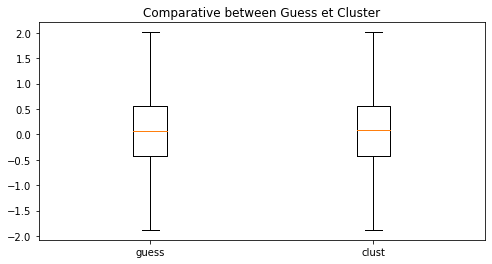

In [92]:
labels = []
plots = []
for key in delta.keys():
    plots.append(delta[key])
    labels.append(key)

plt.figure(figsize=(8,4))
plt.boxplot(plots, labels=labels, showfliers=False)
plt.title("Comparative between Guess et Cluster")
plt.show()

In [93]:
def get_similar_movies_from_users(user_id):
    all_rates = []
    keep_movies = []

    for movie in tqdm(user_title_df.columns):
        if (pd.isnull(user_title_df.loc[user_id, movie])):
            all_rates.append(guess_rate(user_id, movie))
            keep_movies.append(movie)

    return pd.Series(all_rates, keep_movies).sort_values(ascending=False)

In [95]:
get_similar_movies_from_users(3)

  0%|          | 0/500 [00:00<?, ?it/s]

One Flew Over the Cuckoo's Nest (1975)      4.521912
Princess Mononoke (Mononoke-hime) (1997)    4.453064
Fargo (1996)                                4.376970
12 Angry Men (1957)                         4.340207
Requiem for a Dream (2000)                  4.309277
                                              ...   
Truth About Cats & Dogs, The (1996)         1.655610
Father of the Bride Part II (1995)          1.506951
Wild Wild West (1999)                       1.497747
First Knight (1995)                         1.490886
Sabrina (1995)                              1.000000
Length: 301, dtype: float64

## 4.2 - Movie to movie

In [97]:
user_title_std = user_title_df.apply(standardize, axis=0).fillna(0)
user_title_std.shape

(24710, 500)

In [98]:
#Création de la matrice de cosinus distance
cos = cosine_similarity(user_title_std.T)
cos_movies_df = pd.DataFrame(cos, index=user_title_std.columns, columns=user_title_std.columns)
np.fill_diagonal(cos_movies_df.values, 0)
del(cos)

In [99]:
def get_similar_movies_from_movies(user_id):
    similar_movies = pd.DataFrame()

    movies_rates = user_title_df.loc[user_id].dropna()
    movies = movies_rates.index
    rates = movies_rates.values
    user = [(movies[i], rates[i]) for i in range(len(rates))]

    for movie, rate in tqdm(user):
        movie_list = (cos_movies_df.loc[:, movie]*(rate-2.5)).sort_values(ascending=False)
        similar_movies = similar_movies.append(movie_list)

    
    similar_movies = similar_movies.T.drop([movie for movie, rate in user], axis=0)
    return similar_movies.sum(axis=1).sort_values(ascending=False)

In [100]:
get_similar_movies_from_movies(3)

  0%|          | 0/199 [00:00<?, ?it/s]

Saving Private Ryan (1998)                             40.106259
Spider-Man 2 (2004)                                    39.596884
Sixth Sense, The (1999)                                38.783319
Indiana Jones and the Last Crusade (1989)              38.465264
Up (2009)                                              37.900991
                                                         ...    
City Slickers II: The Legend of Curly's Gold (1994)    11.547058
Congo (1995)                                           11.474667
French Kiss (1995)                                     11.226061
Executive Decision (1996)                              10.659839
Disclosure (1994)                                       9.076215
Length: 301, dtype: float64

## 4.3 - Mix

In [150]:
user = cluster.index[1]

get_users = get_similar_movies_from_users(user).index
get_movies = get_similar_movies_from_movies(user).index

arg_movies = []
for title in get_users:
    arg_movies.append(int(np.argwhere(get_movies == title)))

recommanded = pd.DataFrame(index=get_users, columns=["Arg Users", "Arg Movies"], data=np.array([range(len(arg_movies)), arg_movies]).T)
recommanded["Mean"] = recommanded.mean(axis=1)

recommanded.sort_values(by="Mean")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

,Arg Users,Arg Movies,Mean
Star Wars: Episode VI - Return of the Jedi (1983),6,5,5.5
Memento (2000),11,9,10.0
X-Men (2000),15,6,10.5
Pirates of the Caribbean: The Curse of the Black Pearl (2003),16,8,12.0
Die Hard (1988),26,1,13.5
...,...,...,...
Ed Wood (1994),190,202,196.0
Fantasia (1940),195,200,197.5
Johnny Mnemonic (1995),185,210,197.5
First Knight (1995),200,205,202.5
